# The Fermi-Pasta-Ulam-Tsingou Problem

In [1]:
"""
================================================================
        The Fermi-Pasta-Ulam-Tsingou (FPUT) Problem (1D)
================================================================
"""
import glob
from math import log10
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi as PI
import os
import re
from scipy.interpolate import interp1d

#   Improve performance by applying 'jit' decorator
from numba import jit

__version__ = '1.0'

#   Color-friendly colors!
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = CB_color_cycle)
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", CB_color_cycle)
del CB_color_cycle


In [2]:
################################################################################
#                                                                              #
#                            CONSTANTS & PARAMETERS                            #
#                                                                              #
################################################################################

N, ALPHA, BETA, N_MODES, config_str, dt, time_points, y0_amp = (None,) * 8

def init_constants(mN = 2 ** 5, mALPHA = 1.0, mBETA = 1e-1, mN_MODES = 3, mt_max = 1e5, mdt_mantissa = 2.5, mdt_exp = -2):
    """
    Initializes constants and parameters;
    if new simulation conditions are required, pass in values for said values (else default values will be used)

    :param  mN:             parameter N
    :param  mALPHA:         parameter ALPHA
    :param  mBETA:          parameter BETA
    :param  mN_MODES:       parameter N_MODES
    :param  mt_max:         parameter mt_max

    :param  dt_mantissa:    Mantissa of dt (float)
    :param  dt_exp:         Exponent of dt (int)
    """
    global N, ALPHA, BETA, N_MODES, config_str, dt, time_points, y0_amp

    N = mN                                          #   Number of masses

    ALPHA = mALPHA                                  #   Linear spring constant
    BETA = mBETA                                    #   Nonlinear spring constant

    N_MODES = mN_MODES                              #   Number of initial modes

    t_max = mt_max                                  #   Maximum time

    config_str = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}_{int(N_MODES)}"
    config_str += f"_{int(log10(t_max))}_{str(mdt_mantissa).replace('.', "d")}({int(mdt_exp)})"

    dt = mdt_mantissa * 10 ** mdt_exp                 #   Time step
    
    num_steps = int(np.ceil(t_max / dt)) + 1        #   Number of time steps
    time_points = np.linspace(0, t_max, num_steps)
    y0_amp = 1.0                                    #   Initial displacement amplitude
                                                    #   for the first and last points
                                                    #   Chosen as 1 for normalized outputs
    
    #   Create subfolders if missing
    os.makedirs(f'./{config_str}', exist_ok = True)
    os.makedirs('./subset_data', exist_ok = True)
    os.makedirs('./subset_data/time_points', exist_ok = True)

    return None

init_constants()


In [ ]:
#   ANIMATION PARAMETERS
frame_step = None

def set_frame_step(total_frames, duration, fps = 60):
    global frame_step

    if total_frames // (duration * fps) == 0:
        frame_step = 1
    else:
        frame_step = total_frames // (duration * fps)          #   To ensure the GIF has 14400 frames

    #   Assuming N = 64 for duration...
    #   FOR     1e3 frames set 30 for non-rotating
    #   FOR     1e3 frames set 45 for rotating
    #   FOR     1e4 frames set 240 for non-rotating
        
    return None
        
set_frame_step(len(time_points), 300)


## The Model

Let there be $N$ oscillators representing a string of length $\ell$ with equilibrium positions $r_i = ih$, $i = 0,\dots,~N - 1$, where $h = \frac{\ell}{N - 1}$ is the lattice spacing

Then the position of the $i$-th oscillator as a function of time is $Y_i\left(t\right) = r_i + y_i\left(t\right)$, so that $y_i\left(t\right)$ gives the displacement from equilibrium. FPUT used the following equations of motion:

$$m\ddot{y}_i = \alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)\left[1 + \beta\left(y_{i + 1} - y_{i - 1}\right)\right]$$
where for unambiguity, $k = \alpha$

which is just Newton's second law for the $i$-th particle. The first factor $\alpha\left(y_{i + 1} + y_{i - 1} - 2y_i\right)$ is just the usual Hooke's law form for the force. The factor with $\beta$ is the nonlinear force

For all intents and purposes, $m$ is set to unity

Crucially, since this is a 1 dimensional model, we have to decide how we tackle the problem of the boundary particles. There are two approaches -- 1. periodic, and 2. fixed

In [3]:
#   Periodic boundary
@jit
def oneD_periodic(y, v):
    """
    List of ODEs of dvdt following periodic boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    #   Displaces numpy array to the left and right for computation
    left_neighbors, right_neighbors = np.roll(y, 1), np.roll(y, -1)
    
    dvdt = ALPHA * (left_neighbors + right_neighbors - 2 * y) * (1 + BETA * (right_neighbors - left_neighbors))

    return v, dvdt


In [4]:
#   Fixed boundary
@jit
def oneD_fixed(y, v):
    """
    List of ODEs of dvdt following fixed boundary conditions; dydt are all v
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    
    :return v:      numpy array of dydt values
    :return dvdt:   numpy array of dvdt values
    """
    dvdt = np.zeros_like(y)             #   Initialize dvdt
    
    #   Interior particles
    dvdt[1:N - 1] = ALPHA * (y[2:N] + y[:N - 2] - 2 * y[1:N - 1]) * (1 + BETA * (y[2:N] - y[:N - 2]))

    #   Boundary particles
    dvdt[0] = ALPHA * (y[1] - 2 * y[0]) * (1 + BETA * y[1])
    dvdt[N - 1] = ALPHA * (y[N - 2] - 2 * y[N - 1]) * (1 + BETA * (- y[N - 2]))

    return v, dvdt


By symmetry, the expression is notably one-dimensional, acting only on the direction perpendicular to the line spanning the equilibrium positions of the oscillators

## ODE Solvers
Consider an ODE of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable

We adopt two types of ODE Solvers
1. Runge-Kutta 4 Method
2. Euler's Method
### Runge-Kutta 4 Method (RK4)
The Runge-Kutta 4 (RK4) method is a numerical technique used to solve ordinary differential equations (ODEs) of the form:
$$\frac{dy}{dt} = f\left(t,~y\right)$$
where `y` is the dependent variable, and `t` is the independent variable. The RK4 method calculates the solution by taking the weighted average of four increments, where each increment is estimated at different points within the given interval. Here are the steps of the RK4 method:
1. **Calculate the first increment** (`k1`), which is the value of the derivative at the beginning of the interval:
   $$k_1 = f\left(t_n,~y_n\right)$$
2. **Calculate the second increment** (`k2`), which is the value of the derivative at the midpoint of the interval, using `k1` to make an estimate for the midpoint value of `y`:
   $$k_2 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_1 \cdot \Delta t}{2}\right)$$
3. **Calculate the third increment** (`k3`), again evaluating the derivative at the interval's midpoint but now using `k2` for the estimation:
   $$k_3 = f\left(t_n + \frac{\Delta t}{2},~y_n + \frac{k_2 \cdot \Delta t}{2}\right)$$
4. **Calculate the fourth increment** (`k4`), which is the value of the derivative at the end of the interval, using k3 to estimate the end value of `y`:
   $$k_4 = f\left(t_n + \Delta t,~y_n + k_3 \cdot \Delta t\right)$$
5. **Combine the increments** to produce the final value of `y` at the next time step ($t_{n + 1}$):
   $$y_{n + 1} = y_n + \frac{\Delta t}{6} \left(k_1 + 2k_2 + 2k_3 + k4\right)$$
#### Advantages of RK4
- **Accuracy**: RK4 is a fourth-order method, which means the local truncation error is of the order of $O\left(Δt^5\right)$, while the total accumulated error is of order $O\left(Δt^4\right)$
- **No Higher Derivatives Needed**: Unlike Taylor series methods, RK4 does not require the calculation of higher-order derivatives
- **Widely Used**: It strikes a balance between computational efficiency and accuracy, making it suitable for a wide range of problems
### Euler's Method
Euler's Method is one of the simplest numerical techniques for approximating solutions to ordinary differential equations (ODEs), providing a quick estimate of the solution's behavior. Euler's Method approximates the solution by stepping forward in small increments, $\Delta t$, and using the derivative's value to estimate the slope of the solution curve. The procedure for Euler's method is straightforward:
1. **Start with initial conditions**:
   $$y\left(t_0\right) = y_0$$
2. **Calculate the next value of `y`**:
   $$y_{n + 1} = y_n + f\left(t_n,~y_n\right) \cdot \Delta t$$

   where $y_{n + 1}$ is the estimate of the solution at time $t_{n + 1} = t_n + \Delta t$, $y_n$ is the current value, and $f\left(t_n,~y_n\right)$ is the value of the derivative function at $t_n$
### Advantages and Disadvantages
- **Simplicity**: Euler's Method is conceptually simple and easy to implement
- **Speed**: It is computationally fast because it requires only one function evaluation per step
- **Accuracy and Stability**: It is not very accurate or stable, especially for stiff equations or when a large step size is used. The global error of Euler's method is proportional to the step size, making it a first-order method

In [5]:
#   Runge-Kutta 4th order method
@jit
def rk4_step(y, v, dt, func):
    """
    Runge-Kutta 4th order ODE Solver
    
    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    k1_y, k1_v = func(y, v)
    k2_y, k2_v = func(y + dt / 2 * k1_y, v + dt / 2 * k1_v)
    k3_y, k3_v = func(y + dt / 2 * k2_y, v + dt / 2 * k2_v)
    k4_y, k4_v = func(y + dt * k3_y, v + dt * k3_v)
    
    y_next = y + dt / 6 * (k1_y + 2 * k2_y + 2 * k3_y + k4_y)
    v_next = v + dt / 6 * (k1_v + 2 * k2_v + 2 * k3_v + k4_v)
    
    return y_next, v_next


In [6]:
# Euler's method
@jit
def euler_step(y, v, dt, func):
    """
    Euler step ODE Solver

    :param  y:      numpy array of y values
    :param  v:      numpy array of v values
    :param  dt:     timestep
    :param  func:   ODE expression

    :return y_next: numpy array of successive y values
    :return v_next: numpy array of successive v values
    """
    dy, dv = func(y, v)
    
    y_next = y + dt * dy
    v_next = v + dt * dv

    return y_next, v_next


## Initial conditions
The initial conditions set the stage for the dynamics that follow. Below are three different methods to initialize the system, each designed to explore different aspects of the nonlinear dynamics in the system
1. $n$-mode
2. Localized
3. ~~Random~~
### $n$-Modes Excitation
In the $n$-modes excitation initialization, the system starts with the particles arranged in a sinusoidal pattern. The amplitude of the sinusoidal wave represents the excitation amplitude, and the mode number specifies the number of half wavelengths fitted into the chain. Additionally, all particles start with zero initial velocity. This setup mimics a pure standing wave in the system, with all particles initially at rest, and is typically used to explore the system's energy distribution and transfer among the modes over time
### Localized Excitation
Localized excitation initialization creates a scenario where only a localized section of the system is energized; here, we adopted to excite only the first and last particles by displacing them by a specified amplitude, while all other particles remain in their equilibrium positions. This simulates a situation akin to an impulsive impact at the boundaries of the particle chain. All particles start with zero initial velocity, allowing the study of energy propagation and reflection in a system with localized disturbances
### ~~Random Excitation~~
~~Random excitation initialization distributes energy across the system in a non-deterministic manner. Each particle is assigned a random displacement and velocity, reflecting a state that could be seen in a thermalized system or a system in which the exact initial conditions are unknown or subject to fluctuations. This type of initialization is often used to investigate the route to equilibrium and the statistical properties of the FPUT system~~

In [7]:
#   Initialized to n modes excitation
def initialize_n_mode(N, mode_no, amp = y0_amp):
    """
    Initialize the system for single mode excitation

    :param  N:      number of particles
    :param  mode_no number of modes
    :param  amp:    excitation amplitude

    :return y:      numpy array of displacements
    :return v:      numpy array of velocities
    """
    n = np.linspace(1, N, N)
    
    y = amp * np.sin(mode_no * np.pi * n / (N + 1))     #   Initialize displacements as
                                                        #   the nth mode sine wave
    v = np.zeros(N)                                     #   Initialize velocities to zero
    
    return y, v


In [8]:
#   Initialized to localized excitation
@jit
def initilize_localized(N, mode_no, amp = y0_amp):
    """
    Initialize the system for localized excitation

    :param  N:          number of particles
    :param  mode_no:    number of modes
    :param  amp:        excitation amplitude

    :return y:      numpy array of displacements
    :return v:      numpy array of velocities
    """
    #   Initial conditions
    y = np.zeros(N)                 #   Displacements
    v = np.zeros(N)                 #   Velocities

    y[0] = amp                      #   Initial displacements
    y[N - 1] = amp
    
    return y, v


In [9]:
# #   Initialized to random excitation
# @jit
# def initialize_random(N, mode_no, amp = y0_amp):
#     """
#     Initialize the system for random excitation

#     :param  N:      number of particles
#     :param  mode_no number of modes
#     :param  amp:    excitation amplitude

#     :return y:      numpy array of displacements
#     :return v:      numpy array of velocities
#     """
#     # Generate random displacements and velocities
#     displacements = np.random.uniform(-amp, amp, N)
#     velocities = np.random.uniform(-0.01, 0.01, N)
    
#     return displacements, velocities


## Simulation
The `oneD_simulator` function is designed to simulate the time evolution of a system of coupled oscillators using a specified ordinary differential equation (ODE) solver. It takes in the following higher-order functions (defined earlier) to improve reusability
- `ode_solver`: type of ODE solver
    - `rk4_step`
    - `euler_step`
- `init_func`: specifies initial conditions
    - `initialize_n_mode`
    - `initilize_localized`
    - `initialize_random`
- `mode`: specifies the $n$ number of modes in`initialize_n_mode`
- `expression`: type of boundary conditions
    - `oneD_periodic`
    - `oneD_fixed`

In [10]:
def oneD_simulator(ode_solver, init_func, mode, expression):
    """
    Simulates time evolution of the oscillators

    :param  ode_solver: ODE Solving algorithm
    :param  init_func:  type of initilization
    :param  mode:       number of modes
    :param  expression: ODE expression
    
    :return d:          numpy array of displacements for each timestep
    :return v:          numpy array of velocities for each timestep
    """
    #   Initial conditions
    y, v = init_func(N, mode)

    #   Time evolution
    displacements = [y.copy()]      #   2D array of displacements at each time step
    velocities = [v.copy()]         #   2D array of velocities at each time step
    for _ in time_points:
        y, v = ode_solver(y, v, dt, expression)
        displacements.append(y.copy())
        velocities.append(v.copy())

    return np.array(displacements), np.array(velocities)

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [11]:
#   Simulate FPUT
displacements_1D_periodic, velocities_1D_periodic = oneD_simulator(rk4_step, initialize_n_mode, N_MODES, oneD_periodic)
displacements_1D_fixed, velocities_1D_fixed = oneD_simulator(rk4_step, initialize_n_mode, N_MODES, oneD_fixed)


## Miscellaneous

### ~~Saving Data~~

In [12]:
# #   Save complete numpy dump file
# np.savetxt(f'./{config_str}/displacements_1D_periodic_{config_str}.txt', displacements_1D_periodic)
# np.savetxt(f'./{config_str}/velocities_1D_periodic_{config_str}.txt', velocities_1D_periodic)
# np.savetxt(f'./{config_str}/displacements_1D_fixed_{config_str}.txt', displacements_1D_fixed)
# np.savetxt(f'./{config_str}/velocities_1D_fixed_{config_str}.txt', velocities_1D_fixed)


### Generate `subset_data` for optimal timestep testing

In [13]:
def save_subset(fn, data):
    """
    Save data subset (corresponding to the gif)
    """
    subset = data[:, int(np.ceil(N / 3))]
    np.savetxt(f'./subset_data/{fn}_{config_str}.txt', subset)

    return None


In [14]:
# #   Generate subset data for time_step_analysis
# #   2D list of `dt_mantissa' and `dt_exp'
# time_steps = [
#     [1, 0], [7.5, -1], [5, -1], [2.5, -1], [1, -1],
#     [7.5, -2], [5, -2], [2.5, -2], [1, -2],
#     [7.5, -3], [5, -3], [2.5, -3], [1, -3], [7.5, -4]
# ]
# #   Timesteps above 7.5e-4 are too small and generate files that are too big

# for mantissa, exp in time_steps:
#     init_constants(mantissa, exp)

#     displacements_1D_periodic, velocities_1D_periodic = oneD_simulator(rk4_step, initialize_n_mode, N_MODES, oneD_periodic)
#     displacements_1D_fixed, velocities_1D_fixed = oneD_simulator(rk4_step, initialize_n_mode, N_MODES, oneD_fixed)

#     #   Save time points
#     np.savetxt(f'./subset_data/time_points/{config_str}.txt', time_points)

#     #   Save subset numpy dump file
#     save_subset('displacements_1D_periodic', displacements_1D_fixed)
#     save_subset('displacements_1D_fixed', displacements_1D_periodic)
#     save_subset('velocities_1D_periodic', velocities_1D_periodic)
#     save_subset('velocities_1D_fixed', velocities_1D_fixed)

#     print(f"Time step {str(mantissa * 10 ** exp)} generated")


### Test for optimal timestep

In [15]:
def load_subset_data(filenames):
    datasets = {
        'displacements_1D_fixed': {},
        'displacements_1D_periodic': {},
        'velocities_1D_fixed': {},
        'velocities_1D_periodic': {}
    }

    for fn in filenames:
        matched = re.match(r'./subset_data/([a-z]+_1D_[a-z]+)_(\d+)_([\dd]+)_([\dd]+)_(\d+)_(\d+)_([\dd]+)\((-?\d+)\)', fn, re.IGNORECASE)

        if matched:
            loaded_data = np.loadtxt(fn)

            class_type, N, ALPHA, BETA, N_MODES, t_max, dt_mantissa, dt_exp = matched.groups()

            ALPHA = float(ALPHA.replace('d', '.'))
            BETA = float(BETA.replace('d', '.'))
            t_max = 10 ** int(t_max)
            dt = float(dt_mantissa.replace('d', '.')) * 10 ** int(dt_exp)
            config_str = f"{int(N)}_{str(ALPHA).replace('.', "d")}_{str(BETA).replace('.', "d")}"
            config_str += f"_{int(log10(t_max))}_{str(dt_mantissa).replace('.', "d")}({int(dt_exp)})"

            num_steps = int(np.ceil(t_max / dt)) + 1        #   Number of time steps
            time_points = np.linspace(0, t_max + dt, num_steps + 1)

            datasets[class_type][fn] = {
                'count': N,
                'alpha': ALPHA,
                'beta': BETA,
                'n_modes': N_MODES,
                't_max': t_max,
                'time_step': dt,
                'time_points': time_points,
                'time_points_len': len(time_points),
                'data': loaded_data,
                'data_len': len(loaded_data)
            }
        else:
            print(f"{class_type}_{config_str} failed to load!")

    return datasets


In [16]:
def find_smallest_time_points_len(dictionary):
    smallest_value = None
    
    def recursive_search(dictionary):
        nonlocal smallest_value
        
        for key, value in dictionary.items():
            if type(value) is dict:
                recursive_search(value)
            elif key == "time_points_len":
                if smallest_value is None or value < smallest_value:
                    smallest_value = value
    
    recursive_search(dictionary)
    
    return smallest_value


In [17]:
def interpolate_dataset(original_time_points, data, common_time_points):
    interpolator = interp1d(original_time_points, data, kind = 'linear', fill_value = "extrapolate")
    return interpolator(common_time_points)


In [ ]:
def interpolate_data():
    datasets = load_subset_data(glob.glob(f'./subset_data/*.txt'))

    common_time_points = np.linspace(0, 1e4, find_smallest_time_points_len(datasets))

    for key, value in datasets.items():
        for fn, details in value.items():
            original_time_points = details['time_points']
            data = details['data']

            interpolated_data = interpolate_dataset(original_time_points, data, common_time_points)
            
            datasets[key][fn]['interpolated_data'] = interpolated_data

    return datasets


In [18]:
@jit
def calculate_rmse(data1, data2):
    mse = np.mean((data1 - data2) ** 2)
    rmse = np.sqrt(mse)
    return rmse


In [ ]:
def analyze_rmse_data(datasets):
    errors = {}

    for key, value in datasets.items():
        reference_data = value[f'./subset_data/{key}_64_1d0_0d1_2_4_7d5(-4).txt']['interpolated_data']

        errors_key = []

        for fn, details in value.items():
            rmse_value = calculate_rmse(reference_data, details['interpolated_data'])
            errors_key.append([details['time_step'], rmse_value])

        errors[key] = np.array(errors_key)
    
    return errors


In [19]:
def plot_rmse_series():
    datasets = interpolate_data()

    errors = analyze_rmse_data(datasets)

    # Loop through the datasets dictionary
    for label, data in errors.items():
        # Log-log plot for the data points
        plt.loglog(data[:, 0], data[:, 1], label = label, marker = '.', markersize = 5, ls = '-', lw = 0)

    plt.title(r'RMSE compared to $\Delta t = 7.5 \times 10^{-4}$')
    plt.xlabel('Chosen time step')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.legend()

    plt.show()
    plt.close()

    return None


In [20]:
# plot_rmse_series()


We note two anomalies corresponding to time steps $\Delta t = 0.075$ and at $\Delta t = 7.5 \times 10^{-3}$. It is likely that this error arose from unexpected behaviors of `scipy.interpolate` 1D interpolation function. Simiarly, we note that the errors for velocity data tends to be higher for larger time steps

Thus we chose $\Delta t = 0.025$ as our timestep

## Animation
The `gif_plotter` function visualizes the time evolution of vertical displacements in a simulated system by creating an animated GIF/MP4 that illustrates how displacements change over time

In [21]:
def gif_plotter(fn, displacements):
    """
    Animation Plotter function v2.0

    Plots animation visualizing time evolution of vertical displacements
    """
    fig, ax = plt.subplots()

    #    Initial plot of displacement v.s. particle number
    line, = ax.plot(displacements[0, :], marker = '.', markersize = 5, c = 'b')

    #   Gridlines
    ax.axhline(y = 0, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = len(displacements[0]) - 1, c = '#d3d3d3', lw = 0.5, ls = '-')
    ax.axvline(x = 0, c = '#d3d3d3', lw = 0.5, ls = '-')

    #   Set plot limits and labels
    max = np.max(displacements)
    ax.set_ylim(-max, max)
    ax.set_xlabel(r'$n^{\text{th}}$ Particle')
    ax.set_ylabel('Displacement (units)')
    title = ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{fn} ({N} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        line.set_ydata(displacements[frame, :])             #    Successive plot of displacement v.s. particle number
        title.set_text(f'Time: {frame * dt:.2f} units')     #    Update elapsed time in title
        return line, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, len(displacements), frame_step), blit = True)
    ani.save(f'./{config_str}/{fn}_{config_str}.mp4', writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [22]:
# #   Plot animations
# gif_plotter('displacements_1D_periodic', displacements_1D_periodic)
# gif_plotter('displacements_1D_fixed', displacements_1D_fixed)


In [23]:
def circle_gif_plot(fn, displacements):
    """
    3D-1D Animation Plotter function

    Plots 3D circle visualization of time evolution of vertical displacements for periodic boundary conditions
    """
    thetas = np.linspace(0, 2 * PI, N)

    x = np.cos(thetas)
    y = np.sin(thetas)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    
    #    Initial plot of displacement v.s. particle number
    ax.scatter(x, y, displacements[0, :], marker = '.', s = 5, c = 'b')
    ax.plot(np.append(x, x[0]), np.append(y, y[0]), np.append(displacements[0, :], displacements[0, :][0]), c = 'b', marker = '.', markersize = 5, ls = '-', lw = 0.5)

    #   Set plot limits and labels
    max = np.max(displacements)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zlim(-max, max)
    ax.set_zlabel('Displacement (units)')
    ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{fn} ({N} particles)')

    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        ax.cla()
        scatter = ax.scatter(x, y, displacements[frame, :], marker = '.', s = 5, c = 'b')
        ax.plot(np.append(x, x[0]), np.append(y, y[0]), np.append(displacements[frame, :], displacements[frame, :][0]), c = 'b', marker = '.', markersize = 5, ls = '-', lw = 0.5)

        #   Set plot limits and labels
        max = np.max(displacements)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zlim(-max, max)
        ax.set_zlabel('Displacement (units)')
        title = ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, len(displacements), frame_step), blit = True)
    ani.save(f'./{config_str}/{fn}_{config_str}_circle.mp4', writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [24]:
circle_gif_plot('displacements_1D_periodic', displacements_1D_periodic)

For rotating plots, change `init_constants` values to vary results

In [25]:
def rotating_circle_gif_plot(fn, displacements):
    """
    Rotating 3D-1D Animation Plotter function

    Plots 3D circle visualization of time evolution of vertical displacements for periodic boundary conditions while rotating
    """
    thetas = np.linspace(0, 2 * PI, N)

    x = np.cos(thetas)
    y = np.sin(thetas)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    
    #    Initial plot of displacement v.s. particle number
    ax.scatter(x, y, displacements[0, :], marker = '.', s = 5, c = 'b')
    ax.plot(np.append(x, x[0]), np.append(y, y[0]), np.append(displacements[0, :], displacements[0, :][0]), c = 'b', marker = '.', markersize = 5, ls = '-', lw = 0.5)

    #   Set plot limits and labels
    max = np.max(displacements)
    ax.set_zlim(-max, max)
    ax.set_axis_off()
    ax.set_title(f'Time: {0:.3f} units')
    fig.suptitle(f'{fn} ({N} particles)')


    #   Update the y-data of the plot to show the displacements at the current time step
    def update(frame):
        ax.cla()
        scatter = ax.scatter(x, y, displacements[frame, :], marker = '.', s = 5, c = 'b')
        ax.plot(np.append(x, x[0]), np.append(y, y[0]), np.append(displacements[frame, :], displacements[frame, :][0]), c = 'b', marker = '.', markersize = 5, ls = '-', lw = 0.5)

        #   Set plot limits and labels
        max = np.max(displacements)
        ax.set_zlim(-max, max)
        ax.set_axis_off()
        ax.view_init(elev = 30, azim = frame // frame_step * 3)       #   Rotate graph
        title = ax.set_title(f'Time: {frame * dt:.3f} units')

        return scatter, title

    #   Creates and saves animation
    ani = FuncAnimation(fig, update, frames = range(0, len(displacements), frame_step), blit = True)
    ani.save(f'./{config_str}/{fn}_{config_str}_circle.mp4', writer = 'ffmpeg', fps = 60)

    #   Close the plot
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [26]:
# init_constants(mN = 2 ** 1, mN_MODES = 7, mt_max = 1e3)
# displacements_1D_periodic, velocities_1D_periodic = oneD_simulator(rk4_step, initialize_n_mode, N_MODES, oneD_periodic)
# set_frame_step(len(displacements_1D_periodic), 30)
# rotating_circle_gif_plot('displacements_1D_periodic', displacements_1D_periodic)


## Total Energy
`potential_energy` and `kinetic_energy` calculate both the respective potential and kinetic energies at each time step and `total_energy_plotter` visualizes the total energy of the system over time

In [27]:
#   Calculates total potential energy at each time step
def potential_energy(displacements):
    """
    Calculates potential energy of the system at each time step

    :param  displacements:  numpy array of displacements at each time step

    :return total_pe:       numpy array of total potential energy at each time step
    """
    delta_x = displacements - np.roll(displacements, -1, axis = 1)

    pe_linear = 0.5 * ALPHA * (delta_x ** 2)
    pe_nonlinear = (1/3) * BETA * (delta_x ** 3)

    total_pe_linear = np.sum(pe_linear, axis = 1)
    total_pe_nonlinear = np.sum(pe_nonlinear, axis = 1)

    total_pe = total_pe_linear + total_pe_nonlinear

    return total_pe

In [28]:
#   Calculates total kinetic energy at each time step
def kinetic_energy(velocities):
    """
    Calculates kinetic energy of the system at each time step

    :param  velocities:     numpy array of velocities at each time step

    :return total_ke:       numpy array of total kinetic energy at each time step
    """
    ke = 0.5 * (velocities ** 2)

    total_ke = np.sum(ke, axis = 1)

    return total_ke

In [29]:
def total_energy_plotter(fn, displacements, velocities):
    """
    Total energy plotter function

    Plot graph visualizing total energy over time
    """
    plt.stackplot(time_points, potential_energy(displacements[:-1]), kinetic_energy(velocities[:-1]), labels = ['Potential Energy', 'Kinetic Energy'])

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Total Energy')
    plt.title('Total Energy in the system over Time')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{fn}_{config_str}_total_energy.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

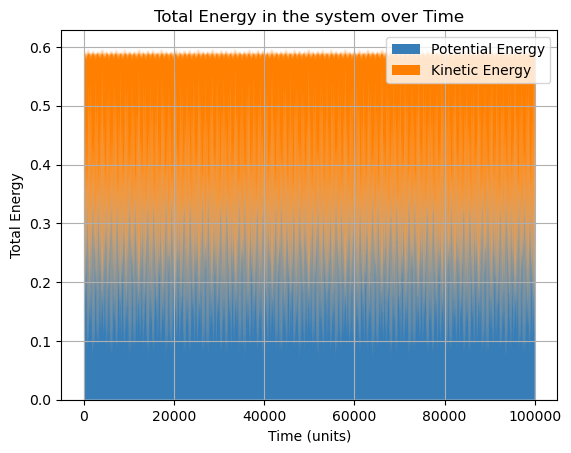

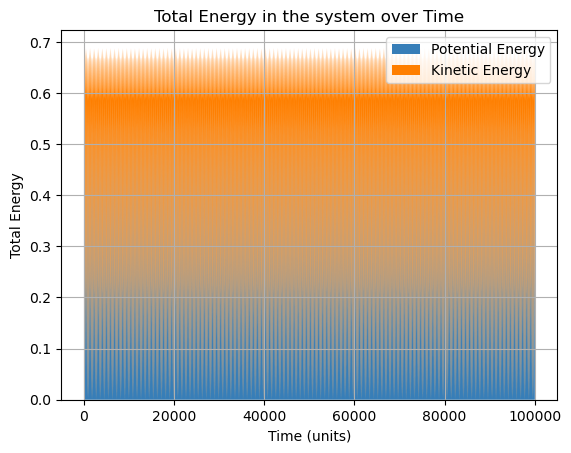

In [30]:
#   Plot total energy
total_energy_plotter('1D_periodic', displacements_1D_periodic, velocities_1D_periodic)
total_energy_plotter('1D_fixed', displacements_1D_fixed, velocities_1D_fixed)


## Mode Energy Analysis
`fft_plotter` analyzes the energy distribution across different modes in a system over time by using the Fast Fourier Transform (FFT)

In [31]:
def fft_plotter(fn, displacements):
    """
    FFT plotter function

    Plot graph visualizing energy distribution across modes
    """
    # Fourier Transform of Displacements to show energy distribution across FFT modes
    fourier_transform = np.fft.rfft(displacements[:-1], axis = 1)
    mode_energies = np.abs(fourier_transform) ** 2

    plt.figure(figsize = (12, 5))
    for i in range(1, 5):  # First four modes after the zero mode
        plt.plot(time_points, mode_energies[:, i], ls = '-', lw = 0.5, label = f'Mode {i}')

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Mode Energy')
    plt.title('Energy in the First Four Modes Over Time')
    plt.suptitle(f'{fn} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{fn}_{config_str}_energy_modes.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

/var/folders/zy/j3l29h_n7l9b4xv6k4jlb8g40000gn/T/ipykernel_44284/167384186.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'./{config_str}/{fn}_{config_str}_energy_modes.png', transparent = True)
/opt/homebrew/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


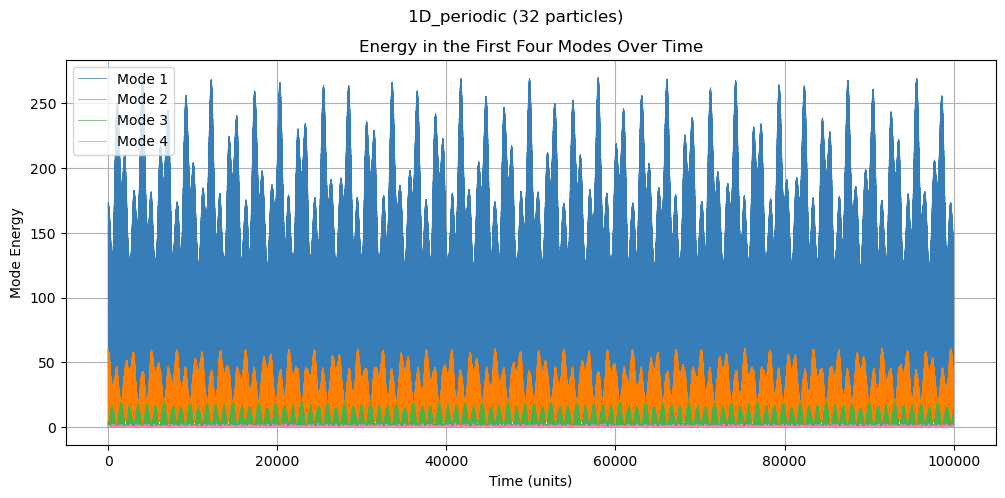

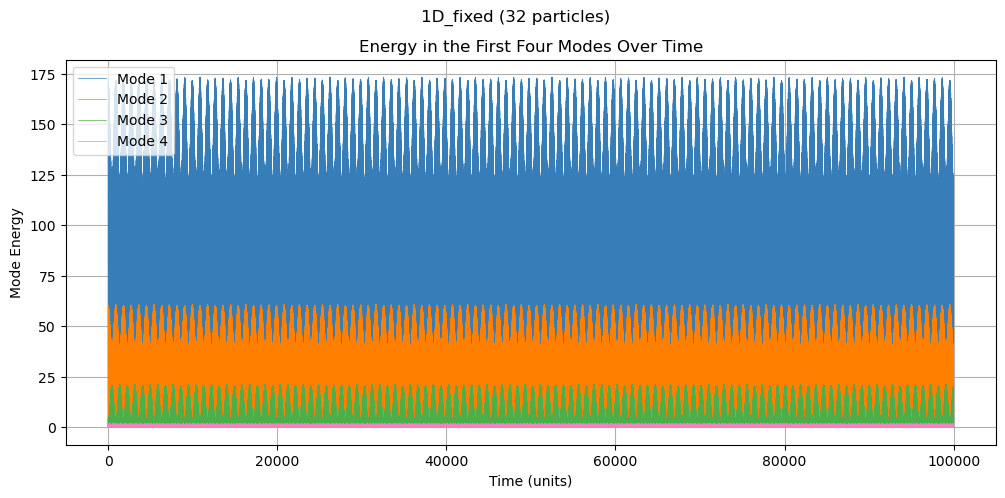

In [32]:
#   Plot FFT
fft_plotter('1D_periodic', displacements_1D_periodic)
fft_plotter('1D_fixed', displacements_1D_fixed)


## ~~Temperature Evolution
~~`temperature_evolution` generates a plot to visualize the `temperature' of a system over time. It is used to track the average kinetic energy, which is related to the kinetic temperature in thermodynamic systems as the mean square of the velocities of the particles in the system~~
$$\left\langle E_{\operatorname{k}}\right\rangle = \frac{1}{2}m\left\langle v^2\right\rangle = \frac{1}{2}k_{\operatorname{B}}T$$
$$T \propto\left\langle v^2\right\rangle$$

In [33]:
def temperature_evolution(fn, velocities):
    """
    Temperature Evolution plotter function

    Plots system 'temperature' against time
    """
    temperature = np.mean(velocities ** 2, axis = 1)
    
    plt.figure(figsize = (12, 5))
    plt.plot(time_points, temperature[:-1], ls = '-', lw = 0.5)

    #   Set plot limits and labels
    plt.grid(True)
    plt.xlabel('Time (units)')
    plt.ylabel('Temperature (units)')
    plt.title(f'Temperature Evolution of the system over time')
    plt.suptitle(f'{fn} ({N} particles)')

    #   Saves plot
    plt.savefig(f'./{config_str}/{fn}_{config_str}_temperature_evolution.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [34]:
# #   Plot temperature evolution
# temperature_evolution('1D_periodic', displacements_1D_periodic)
# temperature_evolution('1D_fixed', displacements_1D_fixed)


## ~~Phase Space Dynamics~~
~~`phase_space_plotter` illustrates the dynamic evolution of a system through phase space trajectories, plotting velocity against displacement for a specific particle in the system~~

In [35]:
## ~~Phase Space Trajectories~~
def phase_space_plotter(filename, displacements, velocities):
    """
    Phase space plotter function

    Plots velocity against displacement in a phase space plot
    """
    particle_index = int(np.ceil(N / 3))

    step = frame_step // 100

    plt.figure(figsize = (12, 5))
    plt.scatter(displacements[:-1:step, particle_index], velocities[:-1:step, particle_index], c = time_points[::step], cmap = 'plasma', marker = '.', s = 1, ls = '-', lw = 0)

    #   Set plot limits and labels
    plt.colorbar(label = 'Time (units)')
    plt.grid(True)
    plt.xlabel('Displacement (units)')
    plt.ylabel('Velocity (units)')
    plt.title(f'Phase Space Trajectory for Particle {particle_index}')
    plt.suptitle(f'{filename} ({N} particles)')
    plt.legend()

    #   Saves plot
    plt.savefig(f'./{config_str}/{filename}_{config_str}_phase_space.png', transparent = True)

    #   Show & close the plot
    plt.show()
    plt.close()
    return None

################################################################################
#                                                                              #
#                          ABOVE CODE USED FOR SET UP                          #
#                                                                              #
################################################################################

In [36]:
# #   Plot phase space trajectories
# phase_space_plotter('1D_periodic', displacements_1D_periodic, velocities_1D_periodic)
# phase_space_plotter('1D_fixed', displacements_1D_fixed, velocities_1D_fixed)


## Lyapunov Exponent

In [37]:
# import nolds

# lyap_exp_periodic = nolds.lyap_e(velocities_1D_periodic, emb_dim = 10, matrix_dim = 2)
# print("Largest Lyapunov Exponent (Periodic):", lyap_exp_periodic)

# lyap_exp_fixed = nolds.lyap_e(velocities_1D_fixed, emb_dim = 10, matrix_dim = 2)
# print("Largest Lyapunov Exponent (Fixed):", lyap_exp_fixed)


In [38]:
# # Preparing the figure and 3D axes
# fig = plt.figure(figsize = (10, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Waterfall plot: plot lines for each timestep
# for i, t in enumerate(time_points[::frame_step]):
#     # Offset each line plot along the z-axis by the current time step
#     ax.scatter(np.arange(N), displacements_1D_periodic[i, :], zs = t, zdir = 'y', marker = '.')

# # Labels and titles
# ax.set_xlabel('Particle Index')
# ax.set_ylabel('Time')
# ax.set_zlabel('Displacement')

# # Set the angle of the view
# ax.view_init(30, -60)  # Elevation and azimuth

# plt.title('Waterfall Plot of Particle Displacements Over Time')
# plt.show()